In [1]:
!pip install metric-learn

In [2]:
import joblib
import matplotlib.pyplot as plt
from metric_learn import NCA, LMNN
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load in the data

In [3]:
# define input files
COMPOSITIONS_FILE = "data/oh2016_species_relative_abundance.csv"
METADATA_FILE = "data/oh2016_metadata.csv"

First we'll load in the microbial compositions of each sample. These are the proportions that each species takes up of the entire sample.

In [4]:
# load in the species abundance table
compositions_df = pd.read_csv(COMPOSITIONS_FILE, index_col="names").transpose()
compositions_df.head()

names,Aeropyrum_pernix,Desulfurococcus_kamchatkensis,Ignicoccus_hospitalis,Staphylothermus_marinus,Hyperthermus_butylicus,Metallosphaera_sedula,Sulfolobus_acidocaldarius,Sulfolobus_islandicus,Sulfolobus_solfataricus,Sulfolobus_tokodaii,...,Nyamanini_nyavirus,Canine_pneumovirus,Pneumonia_virus_of_mice,Respiratory_syncytial_virus,Bovine_parainfluenza_virus,Human_parainfluenza_virus,Vesicular_stomatitis_virus,Bovine_rhinitis_B_virus,Encephalomyocarditis_virus,Grapevine_Pinot_gris_virus
MET0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.038129,0.0,0.0,0.0,0.0,0.0,0.0
MET0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002911,0.0,0.0,0.0,0.0,0.0,0.0
MET0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
MET0011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
MET0012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Next to the compositions, we also have some metadata for each sample:

In [5]:
# load in the metadata
metadata_df = pd.read_csv(METADATA_FILE, index_col="Sample")
to_drop = [i for i in metadata_df.index if i not in compositions_df.index]
metadata_df.drop(index=to_drop, inplace=True)

metadata_df.head()

,Person,Origin,Gender,Age at time of sampling,Date Collected,Timepoint,Site-Symmetry,Method,Site characteristic
Sample,,,,,,,,,
MET0001,person_03,2014 study,Female,30s,06.24.11,First,Ac-L,Ss,moist
MET0002,person_03,2014 study,Female,30s,06.24.11,First,Ph-L,Ss,moist
MET0009,person_01,2014 study,Male,30s,09.30.11,First,Gb-null,Ss,sebaceous
MET0011,person_01,2014 study,Male,30s,09.30.11,First,Ch-R,Ss,sebaceous
MET0012,person_01,2014 study,Male,30s,09.30.11,First,Al-R,Ss,sebaceous


In [6]:
# how many samples do we have per person?
print(np.unique(metadata_df.Person, return_counts=True))

(array(['person_01', 'person_02', 'person_03', 'person_04', 'person_05',
       'person_06', 'person_07', 'person_08', 'person_09', 'person_10',
       'person_11', 'person_12'], dtype=object), array([51, 50, 49, 49, 43, 49, 41, 51, 51, 50, 51, 50]))


# Learning the individuals from the data

We have between 41 and 51 samples from each of the 12 individuals, which we can use to teach a machine learning model to learn the individuals in the data. If it is able to do this effectively, we could then use the same model to predict from which person a new sample originated.

## Split off a 'train' and 'test' set
To get an idea of how good our machine learning model is at identifying people from their microbial samples, we want to see how well it is on data it has not seen before. To do this, we will first split off a few samples from the data before we train a model on it.

In [7]:
compositions_train, compositions_test, labels_train, labels_test = train_test_split(compositions_df, metadata_df["Person"], test_size=0.2, random_state=42, stratify=metadata_df["Person"])

## Metric learning 
Metric learning is a type of machine learning that projects labelled data into a new space where similarly labelled objects will fall close to each other. We will attempt two metric learning models here: 

1. **Neighborhood Components Analysis (NCA):**
    NCA is a distance metric learning algorithm which aims to improve the accuracy of nearest neighbors classification compared to the standard Euclidean distance. The algorithm directly maximizes a stochastic variant of the leave-one-out k-nearest neighbors (KNN) score on the training set. It can also learn a low-dimensional linear transformation of data that can be used for data visualization and fast classification ([Goldberger et al., 2005](https://proceedings.neurips.cc/paper/2004/file/42fe880812925e520249e808937738d2-Paper.pdf)).

2. **Large Margin Nearest Neighbor Metric Learning (LMNN):**
    LMNN learns a Mahalanobis distance metric in the kNN classification setting. The learned metric attempts to keep close k-nearest neighbors from the same class, while keeping examples from different classes separated by a large margin. This algorithm makes no assumptions about the distribution of the data ([Weinberger et al., 2009](https://jmlr.csail.mit.edu/papers/volume10/weinberger09a/weinberger09a.pdf)).

*FYI: for more laymans terms, both of these algotihms have wikipedia entries as well.* 

In [7]:
# Fit a model to learn the distances in this dataset
nca_metric_learning_model = NCA(max_iter=100, n_components=1000, random_state=42)
lmnn_metric_learning_model = LMNN(max_iter=100, k = 10, learn_rate=1e-6, n_components=1000, random_state=42)
nca_metric_learning_model.fit(compositions_train, labels_train)
lmnn_metric_learning_model.fit(compositions_train, labels_train)

# Transform the compositions according to the learned metrics
nca_transformed_data_train = nca_metric_learning_model.transform(compositions_train)
lmnn_transformed_data_train = lmnn_metric_learning_model.transform(compositions_train)

^^^ note: the LMNN algorithm is quite slow. On an intel i5 macbook pro with 16 GB RAM, the above block takes about 83 minutes to complete in its entirety.

### Understanding our algorithms in 3D
While metric learning can be done in a high-number of dimensions (in the code block above, we do it in 2259), we can get an intuitive understanding of this approach by doing it on samples from persons 1 till 8 and in only 3 dimensions. This way we can plot the transformed data and see how well it places samples from the same people together.

In [26]:
# subset the data to only persons 1 till 8
subset_indexes = [idx for idx, i in enumerate(labels_train) if i in ["person_01", "person_02", "person_03", "person_04", "person_05", "person_06"]]
compositions_subset = compositions_train.iloc[subset_indexes]
labels_subset = labels_train[subset_indexes]

In [9]:
# visualize the NCA algorithm
nca_metric_learning_model_viz = NCA(max_iter=500, n_components=3, random_state=42)
nca_metric_learning_model_viz.fit(compositions_subset, labels_subset)
nca_transformed_data_3D = nca_metric_learning_model_viz.transform(compositions_subset)
fig_3d = px.scatter_3d(nca_transformed_data_3D, x=0, y=1, z=2, color=labels_subset)
fig_3d.update_traces(marker_size=2)

In [23]:
# visualize the LMNN algorithm (this will take about 10min to run)
lmnn_metric_learning_model_viz = LMNN(n_components = 3, k=10, learn_rate=1e-4, random_state=42)
lmnn_metric_learning_model_viz.fit(compositions_subset, labels_subset)
lmnn_transformed_data_3D = lmnn_metric_learning_model_viz.transform(compositions_subset)
fig_3d = px.scatter_3d(lmnn_transformed_data_3D, x=0, y=1, z=2, color=labels_subset)
fig_3d.update_traces(marker_size=2)

## Re-identifying
We can now try to reidentify each of samples in our test set that we kept hidden from the machine learning model. Since we learned a metric to transform the compositions so that samples from the same individual are more closeby, we can do this just by looking for the closest point in this transformed space.

In [8]:
def rank_distances_and_predict(metric_learning_model, train_data, test_data):
    # for each data point, calculate the distances to all other points using the learned metric as distance function
    metric_fun = metric_learning_model.get_metric()
    test_size = test_data.shape[0]
    train_size = train_data.shape[0]
    distances = np.zeros((test_size, train_size))
    for row in range(test_size):
        datapoint_test = test_data.iloc[row, :]
        for col in range(train_size):
            datapoint_train = train_data.iloc[col, :]
            d = metric_fun((datapoint_test), (datapoint_train))
            distances[row, col] = d

    
    # from the distances, make a ranking of the closest people to each of the test set samples
    ranking = []
    for row in distances:
        ranking.append(list(labels_train[np.argsort(row)]))

    # re-identify people by picking the first one from this ranking for each of the test set samples
    predicted_labels = [r[0] for r in ranking] 

    return predicted_labels, ranking

In [12]:
nca_predicted_labels, nca_ranking = rank_distances_and_predict(nca_metric_learning_model, compositions_train, compositions_test)
lmnn_predicted_labels, lmnn_ranking = rank_distances_and_predict(lmnn_metric_learning_model, compositions_train, compositions_test)

## Checking performance
We can then check how accurate our model is by comparing the predicted labels with the actual labels. As a baseline, we can compare it to purely random guessed, which should reach a performance of ~1/12 = 8.33%.

In [13]:
# check the accuracy
nca_accuracy = round(accuracy_score(labels_test, nca_predicted_labels) * 100, 2)
print("{}% of samples were correctly reidentified using the NCA method, ".format(nca_accuracy))
lmnn_accuracy = round(accuracy_score(labels_test, lmnn_predicted_labels) * 100, 2)
print("while {}% of samples were correctly reidentified using the LMNN method.".format(lmnn_accuracy))

53.85% of samples were correctly reidentified using the NCA method, 
while 60.68% of samples were correctly reidentified using the LMNN method.


We can look at some more specific metrics as well:

In [14]:
print("==================== NCA metrics =====================")
print(classification_report(labels_test, nca_predicted_labels, target_names=np.unique(metadata_df["Person"])))

==================== NCA metrics =====================
              precision    recall  f1-score   support

   person_01       0.36      0.40      0.38        10
   person_02       0.67      0.60      0.63        10
   person_03       0.60      0.60      0.60        10
   person_04       0.20      0.10      0.13        10
   person_05       0.57      0.44      0.50         9
   person_06       0.90      0.90      0.90        10
   person_07       0.56      0.62      0.59         8
   person_08       0.27      0.30      0.29        10
   person_09       0.73      0.80      0.76        10
   person_10       0.55      0.60      0.57        10
   person_11       0.55      0.60      0.57        10
   person_12       0.42      0.50      0.45        10

    accuracy                           0.54       117
   macro avg       0.53      0.54      0.53       117
weighted avg       0.53      0.54      0.53       117



In [15]:
print("======= LMNN metrics ======")
print(classification_report(labels_test, lmnn_predicted_labels, target_names=np.unique(metadata_df["Person"])))

======= LMNN metrics ======
              precision    recall  f1-score   support

   person_01       0.33      0.40      0.36        10
   person_02       0.50      0.40      0.44        10
   person_03       0.70      0.70      0.70        10
   person_04       0.40      0.40      0.40        10
   person_05       0.83      0.56      0.67         9
   person_06       1.00      1.00      1.00        10
   person_07       0.55      0.75      0.63         8
   person_08       0.43      0.30      0.35        10
   person_09       0.89      0.80      0.84        10
   person_10       0.70      0.70      0.70        10
   person_11       0.54      0.70      0.61        10
   person_12       0.55      0.60      0.57        10

    accuracy                           0.61       117
   macro avg       0.62      0.61      0.61       117
weighted avg       0.62      0.61      0.61       117



We can see that all 9 samples of person 6 can be classified with 100% accuracy! Others, like person 4 and 2 are more difficult though.

Let's take a look at which rank of distance the correct matches are placed:

In [16]:
# find the ranks (in distance) of the correct matches
nca_rank_of_match = []
lmnn_rank_of_match = []
for nca_datapoint_test, lmnn_datapoint_test, true_label in zip(nca_ranking, lmnn_ranking, labels_test):
    nca_rank_of_match.append(nca_datapoint_test.index(true_label))
    lmnn_rank_of_match.append(lmnn_datapoint_test.index(true_label))

nca_below_5 = round(sum([1 for rank in nca_rank_of_match if rank < 5])/len(nca_rank_of_match) * 100, 2)
lmnn_below_5 = round(sum([1 for rank in lmnn_rank_of_match if rank < 5])/len(lmnn_rank_of_match) * 100, 2)
print("For the NCA algorithm, {}% of samples were ranked in the top 5 closest samples, ".format(nca_below_5))
print("and the LMNN algorithm, {}% of samples were ranked in the top 5 closest samples.".format(lmnn_below_5))

For the NCA algorithm, 79.49% of samples were ranked in the top 5 closest samples, 
and the LMNN algorithm, 80.34% of samples were ranked in the top 5 closest samples.


## Optimizing
Given that the LMNN algorithm performs so well, we can try to tweak it to perform even better. We can do that by playing around with the parameters of the model, a process called *tuning the hyperparameters*. We initially called our model as `LMNN(k = 10, learn_rate=1e-6, random_state=42)`, but there are more possible hyperparameters:
- `init`: the type of initialization of the linear transformation. Possible options are 'auto', 'pca', 'identity', 'random'.
- `k`: the number of nearest neighbors from the same class that the algorithm tries to keep close. This will of course depend on how many datapoints we have from any given class (a class referring here to any particular person).
- `max_iter`: maximum number of iterations of the optimization procedure.
- `learn_rate`: learning rate of the optimization procedure.
- `convergence_tol`: tolerance of the optimization procedure. If the objective value varies less than `tol`, the algorithm is considered as converged is stopped.
- `regularization`: relative weight between pull and push terms, with 0.5 meaning equal weight.
- `n_components`: the dimensionality of learned space (*e.g.*, we had set this to 3 for the 3D visualization).

By doing some more complicated searching for good values of each hyperparameter (that will not be included here), we come to the following model:
```
lmnn_metric_learning_model_2 = LMNN(init='auto', 
                                    k = 10, 
                                    max_iter = 500,
                                    learn_rate = 1e-7,
                                    convergence_tol = 0.01,
                                    regularization = 1.0,
                                    n_components = 1000, 
                                    random_state = 42)
lmnn_metric_learning_model_2.fit(compositions_train, labels_train)
```
As this takes quite some time to train, I have exported and attached an already trained version of the model for you, which you can load in with the following block:

In [9]:
lmnn_metric_learning_model_2 = joblib.load('LMNN_trained.model')

In [10]:
predictions, ranking = rank_distances_and_predict(lmnn_metric_learning_model_2, compositions_train, compositions_test)

In [11]:
print("======= model metrics ======")
print(classification_report(labels_test, predictions, target_names=np.unique(metadata_df["Person"])))

======= model metrics ======
              precision    recall  f1-score   support

   person_01       0.67      0.60      0.63        10
   person_02       0.42      0.50      0.45        10
   person_03       0.88      0.70      0.78        10
   person_04       0.86      0.60      0.71        10
   person_05       0.83      0.56      0.67         9
   person_06       1.00      1.00      1.00        10
   person_07       0.75      0.75      0.75         8
   person_08       0.89      0.80      0.84        10
   person_09       0.69      0.90      0.78        10
   person_10       0.77      1.00      0.87        10
   person_11       0.64      0.70      0.67        10
   person_12       0.91      1.00      0.95        10

    accuracy                           0.76       117
   macro avg       0.77      0.76      0.76       117
weighted avg       0.77      0.76      0.76       117



We can save the trained model to file that we can quickly load in again later. Should this not be done already, you can do this using the following command: `joblib.dump(lmnn_metric_learning_model_2, 'LMNN_trained.model')`

## Interpreting
As it seems definite that our algorithm has grabbed onto true signal -*as opposed to just modelling noise*- we can take a deeper look at the metric it has learned to see what the most important species are.

<AxesSubplot:ylabel='Count'>

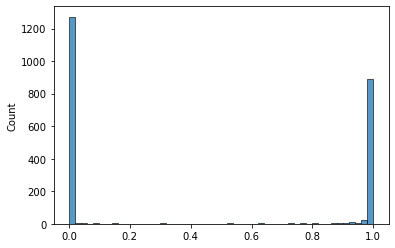

In [20]:
# take a look at the projection matrix the algorithm has learned (the matrix it uses to transform the original datapoints into a space where we can more easily reidentify people)
projection_matrix = lmnn_metric_learning_model_2.get_mahalanobis_matrix()
sb.histplot(np.diagonal(projection_matrix), bins=50)

It seems that quite a lot of the species get scaled to zero, will about a thousand (the number of components/dimensions in our learned space) have an importance of ~1. While interesting in their own right, we'll discard the species whose influence get scaled down a lot and only look at the top 25 species.

In [21]:
interesting_indexes = np.argpartition(np.diagonal(projection_matrix), int(len(projection_matrix)-25))[int(len(projection_matrix)-25):]
interesting_species = {list(compositions_df.columns)[idx]:metric for (idx, metric) in enumerate(np.diagonal(projection_matrix)) if idx in interesting_indexes}

In [22]:
interesting_species

{'Ignicoccus_hospitalis': 0.9999999999806163,
 'Staphylothermus_marinus': 0.9999999999997997,
 'Hyperthermus_butylicus': 0.9999999999764086,
 'Metallosphaera_sedula': 0.999999999970309,
 'Sulfolobus_acidocaldarius': 0.9999999999274581,
 'Sulfolobus_solfataricus': 0.999999999947687,
 'Sulfolobus_tokodaii': 0.9999999999252726,
 'Pyrobaculum_arsenaticum': 0.9999999998164929,
 'Pyrobaculum_islandicum': 0.9999999999883711,
 'Methanocaldococcus_fervens': 0.9999999999803638,
 'Methanocaldococcus_jannaschii': 0.9999999998544228,
 'Methanococcoides_burtonii': 0.9999999998550924,
 'Pyrococcus_furiosus': 0.999999999939742,
 'Pyrococcus_horikoshii': 0.9999999998345721,
 'Thermococcus_sibiricus': 0.9999999998231053,
 'Picrophilus_torridus': 0.9999999999497667,
 'Thermoplasma_volcanium': 0.9999999999042922,
 'Chlamydia_muridarum': 1.0,
 'Chlamydophila_abortus': 0.9999999998792903,
 'Fibrobacter_succinogenes': 0.9999999999826702,
 'Ehrlichia_ruminantium': 0.9999999998193633,
 'Rickettsia_heilongjiang